# Checks if Perfsonar data is indexed

This notebook checks number of indexed documents in all four doc types (latency, packetloss, throughput and traceroute) and alerts if any of them is 0. It sends mails to all the people substribed to that alert. It is run every 30 min from a cron job.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', **{'size': 12})

import pandas as pd

from subscribers import subscribers
import alerts

from datetime import datetime, timedelta
from elasticsearch import Elasticsearch, exceptions as es_exceptions
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

## find all the indices to look at

In [2]:
indices = es.cat.indices(index="network_weather-*", h="index", request_timeout=600).split('\n')
indices = [x for x in indices if x != '']
indices = [x.strip() for x in indices]
#print(indices)

cday = datetime.utcnow()
pday = cday - timedelta(days=1)
#ind1 = 'network_weather-%d.%02d.%02d' % (cday.year, cday.month, cday.day)
#ind2 = 'network_weather-%d.%02d.%02d' % (pday.year, pday.month, pday.day)
ind1 = 'network_weather-%d.%d.%d' % (cday.year, cday.month, cday.day)
ind2 = 'network_weather-%d.%d.%d' % (pday.year, pday.month, pday.day)

print('checking for indices:', ind1, ind2)

ind=[]
if ind1 in indices:
    ind.append(ind1)
if ind2 != ind1 and ind2 in indices and cday.hour<9:   # not necessarily 3, just indicate it is the beginning period of new day
    ind.append(ind2)

if len(ind)==0:
    print('no current indices found. Aborting.')
    exit
else:
    print('will use indices:', ind)

print('current time',datetime.utcnow())

checking for indices: network_weather-2017.6.6 network_weather-2017.6.5
will use indices: ['network_weather-2017.6.6']
current time 2017-06-06 14:14:41.817456


In [3]:
# There is a time offset here - we do now-9 instead of expected now-1. There are two possible reasons:
# a) timestamps are correct but we simply get data with a long delay
# b) timestamps are wrong.

types_query={
   "size": 0,
   "query": {
        "bool":{
            "filter":{
                "range":{"timestamp":{"gt": "now-9h"}}
            }
        }
   },
    "aggs" : {
        "docType" : {
            "terms" : { "field" : "_type" },
             "aggs" : {
                "perHour" : {
                    "date_histogram": {
                        "field": "timestamp",
                        "interval": "1h",
                        "time_zone": "UTC",
                        "min_doc_count": 1
                      }
                }
            }
        }
    }
}

res = es.search(index=ind, body=types_query, request_timeout=120)
#print(res)

total documents: 6275358


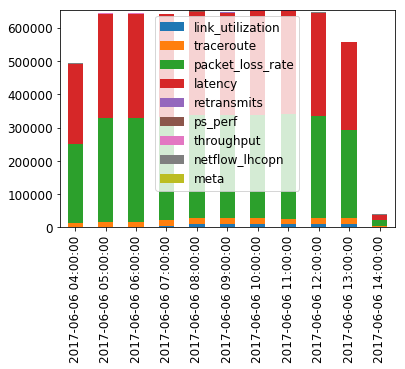

In [4]:
print('total documents:',res['hits']['total'])
counts={}
r=res['aggregations']['docType']['buckets']
for t in r:
#     print(t['doc_count'],t['key'])
    counts[t['key']]={}
    for h in t['perHour']['buckets']:
#         print(h['key'],h['doc_count'])
        counts[t['key']][h['key']]=h['doc_count']
        
dfs=[]
for k, v in counts.items():
    # print(k,v)
    dfs.append(pd.DataFrame({k:v}))

df=pd.concat(dfs,axis=1)
df.index = pd.to_datetime(df.index, unit='ms')
df.plot(kind="bar",stacked=True)

plt.savefig('Images/Check_perfsonar_indexing.png')

In [5]:
types=[
    'latency', 'packet_loss_rate', 'traceroute', 
    'throughput', 'netflow_lhcopn',
    'retransmits',  'ps_perf'
] 

# excluded 'meta' as it is done once per day so could be missing.
# excluded 'link_utilization' as it is some neural network generated crap

if res['hits']['total']>0:
    r=res['aggregations']['docType']['buckets']
    for t in r:
        print(t['key'],t['doc_count'])
        if t['doc_count']>0:
            if t['key'] in types:
                types.remove(t['key'])
            
print('types with no docs:', types)

packet_loss_rate 3014017
latency 2996812
traceroute 165168
link_utilization 68320
netflow_lhcopn 11645
ps_perf 7583
throughput 6272
retransmits 5363
meta 178
types with no docs: []


In [7]:
if len(types) > 0:
    S = subscribers()
    A = alerts.alerts()

    test_name = 'Alert on Elastic indexing rate [PerfSonar]'
    users =  S.get_immediate_subscribers(test_name)
    for user in users:
        
        body = 'Dear ' + user.name+',\n\n'
        body += '\tthis mail is to let you know that there is an issue in indexing Perfsonar data in UC Elasticsearch.\n'
        body += 'These document types have zero documents indexed:\n ' + '\n'.join(types) + '\n'
        A.send_HTML_mail(
            'Networking alert',
            user.email,
            body,
            subtitle=test_name,
            images=[
                    {
                    "Title":'PacketLoss Ingress',
                    "Description":"This plot shows number of documents indexed in last 9 hours per document type. Bins are 1h.",
                    "Filename":"Images/Check_perfsonar_indexing.png",
                    "Link":"http://atlas-kibana.mwt2.org:5601/goto/d183c8a6de184d6fcfa6c41dc531c673"
                    }
                   ]
        )
        

        print(user.to_string())
        A.addAlert(test_name, user.name, str(r))

Adding image: {'Link': 'http://atlas-kibana.mwt2.org:5601/goto/d183c8a6de184d6fcfa6c41dc531c673', 'Filename': 'Images/Check_perfsonar_indexing.png', 'Title': 'PacketLoss Ingress', 'Description': 'This plot shows number of documents indexed in last 9 hours per document type. Bins are 1h.'}
user name:Ilija Vukotic  email:ilija@vukotic.me
Adding image: {'Link': 'http://atlas-kibana.mwt2.org:5601/goto/d183c8a6de184d6fcfa6c41dc531c673', 'Filename': 'Images/Check_perfsonar_indexing.png', 'Title': 'PacketLoss Ingress', 'Description': 'This plot shows number of documents indexed in last 9 hours per document type. Bins are 1h.'}
user name:Ilija Vukotic  email:ilijav@gmail.com
Adding image: {'Link': 'http://atlas-kibana.mwt2.org:5601/goto/d183c8a6de184d6fcfa6c41dc531c673', 'Filename': 'Images/Check_perfsonar_indexing.png', 'Title': 'PacketLoss Ingress', 'Description': 'This plot shows number of documents indexed in last 9 hours per document type. Bins are 1h.'}
user name:Marian Babik  email:mari